#### Autor: José Antonio Fernández Aranda
#### Fecha: Diciembre/2024
#### Contenido:
    Caso de estudio 1.2. Segmentación por alojamientos de tipo apartamento y que se encuentren en el barrio de Centro de Granada, Granada. 
    Inteligencia de Negocio
    Universidad de Granada
#### Documentación sobre clustering en Python:
    http://scikit-learn.org/stable/modules/clustering.html
    http://www.learndatasci.com/k-means-clustering-algorithms-python-intro/
    http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
    https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    http://www.learndatasci.com/k-means-clustering-algorithms-python-intro/

#### Cargamos las librerias empleadas para la realización del caso de estudio

In [130]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN, Birch, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics
from math import floor
import seaborn as sns

#### Definimos la función de normalización de los datos para usarla posteriormente para el procesado de los datos

In [131]:
def norm_to_zero_one(df):
    return (df - df.min()) / (df.max() - df.min())

#### Cargamos los datos de un fichero csv

In [132]:
datos = pd.read_csv('booking_Granada_2024.csv', sep=';', encoding="iso-8859-1")
print(datos.columns.to_list())

['Ranking position', 'Hotel name', 'Price', 'Deal', 'Location', 'Distance', 'Type', 'Quality', 'Rating', 'Special', 'Review', 'Description', 'Bedrooms', 'Living Rooms', 'Bathrooms', 'Kitchens', 'Surface Area (m2)', 'Total Beds', 'Individual Beds', 'Double Beds', 'Double Large Beds', 'Double Extralarge Beds', 'Sofa Beds', 'Bunk Beds', 'Search in advance', 'Guests', 'Average selected price', 'Total of apartments', 'Total of hotels', 'Query date', 'Check in', 'Check out']


#### Realizamos un análisis previo de las variables para conocer que columnas le faltan variables

In [133]:
missing_summary = datos.isnull().sum() 
missing_percentage = (missing_summary / len(datos)) * 100

missing_report = pd.DataFrame({
    'Column': datos.columns,
    'Missing Values': missing_summary,
    'Percentage Missing (%)': missing_percentage
}).sort_values(by='Missing Values', ascending=False)

print(missing_report[missing_report['Missing Values'] > 0])

          Column  Missing Values  Percentage Missing (%)
Deal        Deal          164636               84.647064
Special  Special           98718               50.755539
Type        Type           17506                9.000653


#### Antes de realizar el filtrado, es necesario imputar los valores de nuestro conjunto de datos. Concretamente necesito imputar los valores de Type

In [134]:
datos['Type'].fillna(datos['Type'].mode()[0], inplace=True)


C:\Users\janto\AppData\Local\Temp\ipykernel_6464\1113160100.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  datos['Type'].fillna(datos['Type'].mode()[0], inplace=True)


#### Para comprobar que se han imputado correctamente la variable Type, realizo la siguiente comprobación

In [135]:
missing_summary = datos.isnull().sum() 
missing_percentage = (missing_summary / len(datos)) * 100

missing_report = pd.DataFrame({
    'Column': datos.columns,
    'Missing Values': missing_summary,
    'Percentage Missing (%)': missing_percentage
}).sort_values(by='Missing Values', ascending=False)

print(missing_report[missing_report['Missing Values'] > 0])

          Column  Missing Values  Percentage Missing (%)
Deal        Deal          164636               84.647064
Special  Special           98718               50.755539


In [136]:
valores_unicos_location = datos['Location'].unique()
print("Valores únicos de 'location':")
print(valores_unicos_location)


Valores únicos de 'location':
['Albaicín, Granada' 'Centro de Granada, Granada'
 'Barrio de Ronda, Granada' 'Beiro, Granada' 'Granada' 'Chana, Granada'
 'Genil, Granada' 'Zaidín, Granada' 'Granada Norte, Granada'
 'Sacromonte, Granada']


In [137]:
conteo_location = datos['Location'].value_counts()
print("Conteo de valores en 'location':")
print(conteo_location)


Conteo de valores en 'location':
Location
Centro de Granada, Granada    94351
Barrio de Ronda, Granada      30960
Albaicín, Granada             30189
Granada                       12255
Beiro, Granada                11571
Genil, Granada                 7575
Zaidín, Granada                4261
Chana, Granada                 1984
Sacromonte, Granada             979
Granada Norte, Granada          372
Name: count, dtype: int64


#### Seleccionamos las variables y las renombramos para su tratamiento

In [138]:
variables_filtradas = ['Type','Location', 'Check in', 'Check out', 'Rating','Price', 'Price per Night', 'Nights']
variables_usadas = ['Rating','Price', 'Price per Night', 'Nights']

#### Creación de la variable de precio / noche

In [139]:
X = datos.copy()

X['Check in'] = pd.to_datetime(X['Check in'])
X['Check out'] = pd.to_datetime(X['Check out'])

X['Nights'] = (X['Check out'] - X['Check in']).dt.days

X.loc[X['Nights'] == 0, 'Nights'] = None

X['Price per Night'] = X['Price'] / X['Nights']

print(X[['Price', 'Check in', 'Check out', 'Nights', 'Price per Night']].head())



   Price   Check in  Check out  Nights  Price per Night
0    276 2024-10-28 2024-10-30     2.0            138.0
1    151 2024-10-28 2024-10-30     2.0             75.5
2    162 2024-10-28 2024-10-30     2.0             81.0
3    162 2024-10-28 2024-10-30     2.0             81.0
4    190 2024-10-28 2024-10-30     2.0             95.0


#### He realizado nuevamente la conversión de la variable Type a tipo numérico

In [140]:
X = X[variables_filtradas]

X['Type'] = X['Type'].map({'hotel': 0, 'apartamento': 1})

print(X.head())

   Type                    Location   Check in  Check out  Rating  Price  \
0     1           Albaicín, Granada 2024-10-28 2024-10-30     7.8    276   
1     1  Centro de Granada, Granada 2024-10-28 2024-10-30     8.2    151   
2     1  Centro de Granada, Granada 2024-10-28 2024-10-30     7.7    162   
3     1           Albaicín, Granada 2024-10-28 2024-10-30     9.0    162   
4     1           Albaicín, Granada 2024-10-28 2024-10-30     8.3    190   

   Price per Night  Nights  
0            138.0     2.0  
1             75.5     2.0  
2             81.0     2.0  
3             81.0     2.0  
4             95.0     2.0  


#### Filtramos las variables con los valores que hemos considerado para el estudio

##### Solamente nos quedamos con las vivienda de tipo apartamento

In [141]:
X = X[(X['Type'] == 1)]
print(f"Filtrados por tipo de apartamenros: {len(X)} registros")


Filtrados por tipo de apartamenros: 163613 registros


##### Apartamentos que se encuentren en el barrio de Granada Centro

In [142]:
X = X[X['Location'] == "Centro de Granada, Granada"]
print(f"Filtrados por 'Centro de Granada, Granada' {len(X)} registros")

Filtrados por 'Centro de Granada, Granada' 75806 registros


In [143]:
X = X[variables_usadas]
print(X)

        Rating  Price  Price per Night  Nights
1          8.2    151             75.5     2.0
2          7.7    162             81.0     2.0
5          8.3    230            115.0     2.0
6          9.3    295            147.5     2.0
7          8.6    327            163.5     2.0
...        ...    ...              ...     ...
194483     9.0    664            332.0     2.0
194484     8.7    640            320.0     2.0
194487     7.1    520            260.0     2.0
194490     5.8    520            260.0     2.0
194492     8.0    381            190.5     2.0

[75806 rows x 4 columns]


#### Por último normalizamos el data set 

In [144]:
X_normal = X.apply(norm_to_zero_one)

### Ejecutamos K - means y medimos sus métricas

In [145]:
print('----- Ejecutando k-Means',end='')
k_means = KMeans(init='k-means++', n_clusters=4, n_init=5, random_state=123456)
t = time.time()
cluster_predict = k_means.fit_predict(X_normal) 
tiempo = time.time() - t
print(": {:.5f} segundos, ".format(tiempo), end='')

----- Ejecutando k-Means: 0.51200 segundos, 

##### Calinski Harabasz métrica: 

In [146]:
metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
print("Índice Calinski-Harabasz: {:.5f} ".format(metric_CH), end='')

Índice Calinski-Harabasz: 657915.41788 

##### Silhouette métrica: 

In [147]:
muestra_silhouette = 0.2 if (len(X_normal) > 10000) else 1.0
metric_SC = metrics.silhouette_score(X_normal,cluster_predict,metric='euclidean',sample_size=floor(muestra_silhouette * len(X_normal)),random_state=123456)
print("Silhouette Coefficient: {:.5f}".format(metric_SC))

Silhouette Coefficient: 0.88344


##### Davies Bouldin métrica: 

In [148]:
metric_DB = metrics.davies_bouldin_score(X_normal, cluster_predict)
print("Índice Davies Bouldin: {:.5f} ".format(metric_DB), end='')

Índice Davies Bouldin: 0.15355 

#### Tamaño de los clusters

In [149]:
clusters = pd.DataFrame(cluster_predict, index=X.index, columns=['cluster'])

print("Tamaño de cada cluster:")
size = clusters['cluster'].value_counts().sort_index()

for i, c in size.items():
    print('%d: %5d (%5.2f%%)' % (i+1, c, 100 * c / len(clusters)))


Tamaño de cada cluster:
1: 15154 (19.99%)
2: 58272 (76.87%)
3:  1716 ( 2.26%)
4:   664 ( 0.88%)


#### Visualización: Heatmap de centroides

---------- Heatmap de centroides...


(4.0, 0.0)

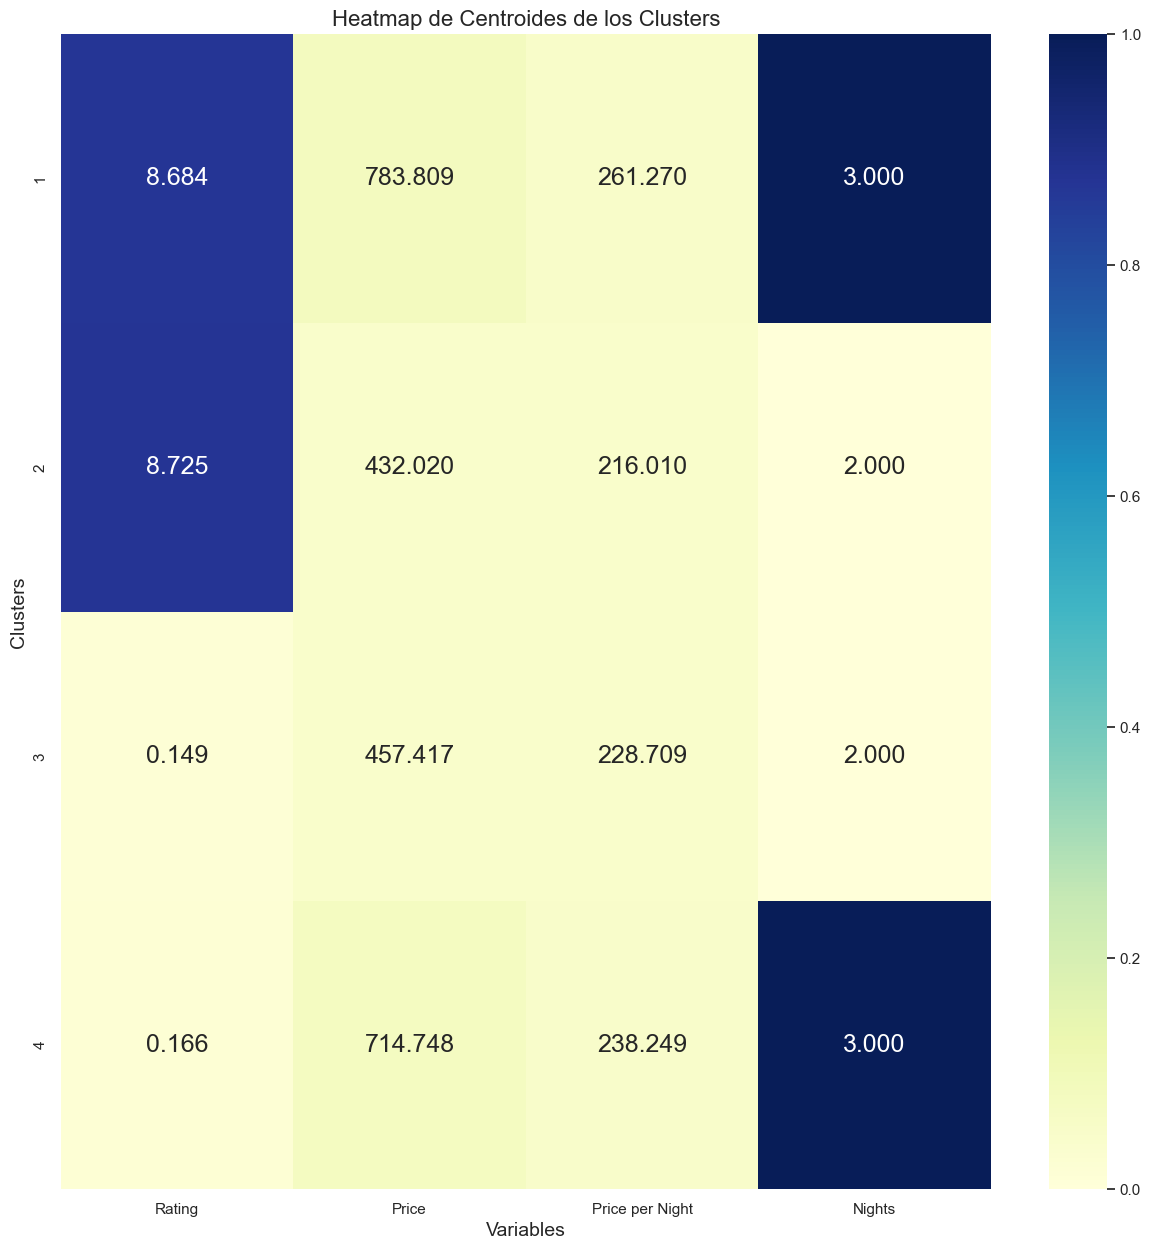

In [150]:
k = len(size)

colors = sns.color_palette(palette='Paired', n_colors=k)

print("---------- Heatmap de centroides...")
centers = pd.DataFrame(k_means.cluster_centers_, columns=list(X))

centers_desnormal = centers.copy()
for var in list(centers):
    centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())

centers.index += 1

plt.figure(figsize=(15, 15))
hm = sns.heatmap(
    centers, 
    cmap="YlGnBu", 
    annot=centers_desnormal, 
    annot_kws={"fontsize": 18}, 
    fmt='.3f'
)
hm.set_title("Heatmap de Centroides de los Clusters", fontsize=16)
hm.set_ylabel("Clusters", fontsize=14)
hm.set_xlabel("Variables", fontsize=14)
hm.set_ylim(len(centers), 0)

#### Visualización: Scatter Matrix

---------- Scatter matrix...


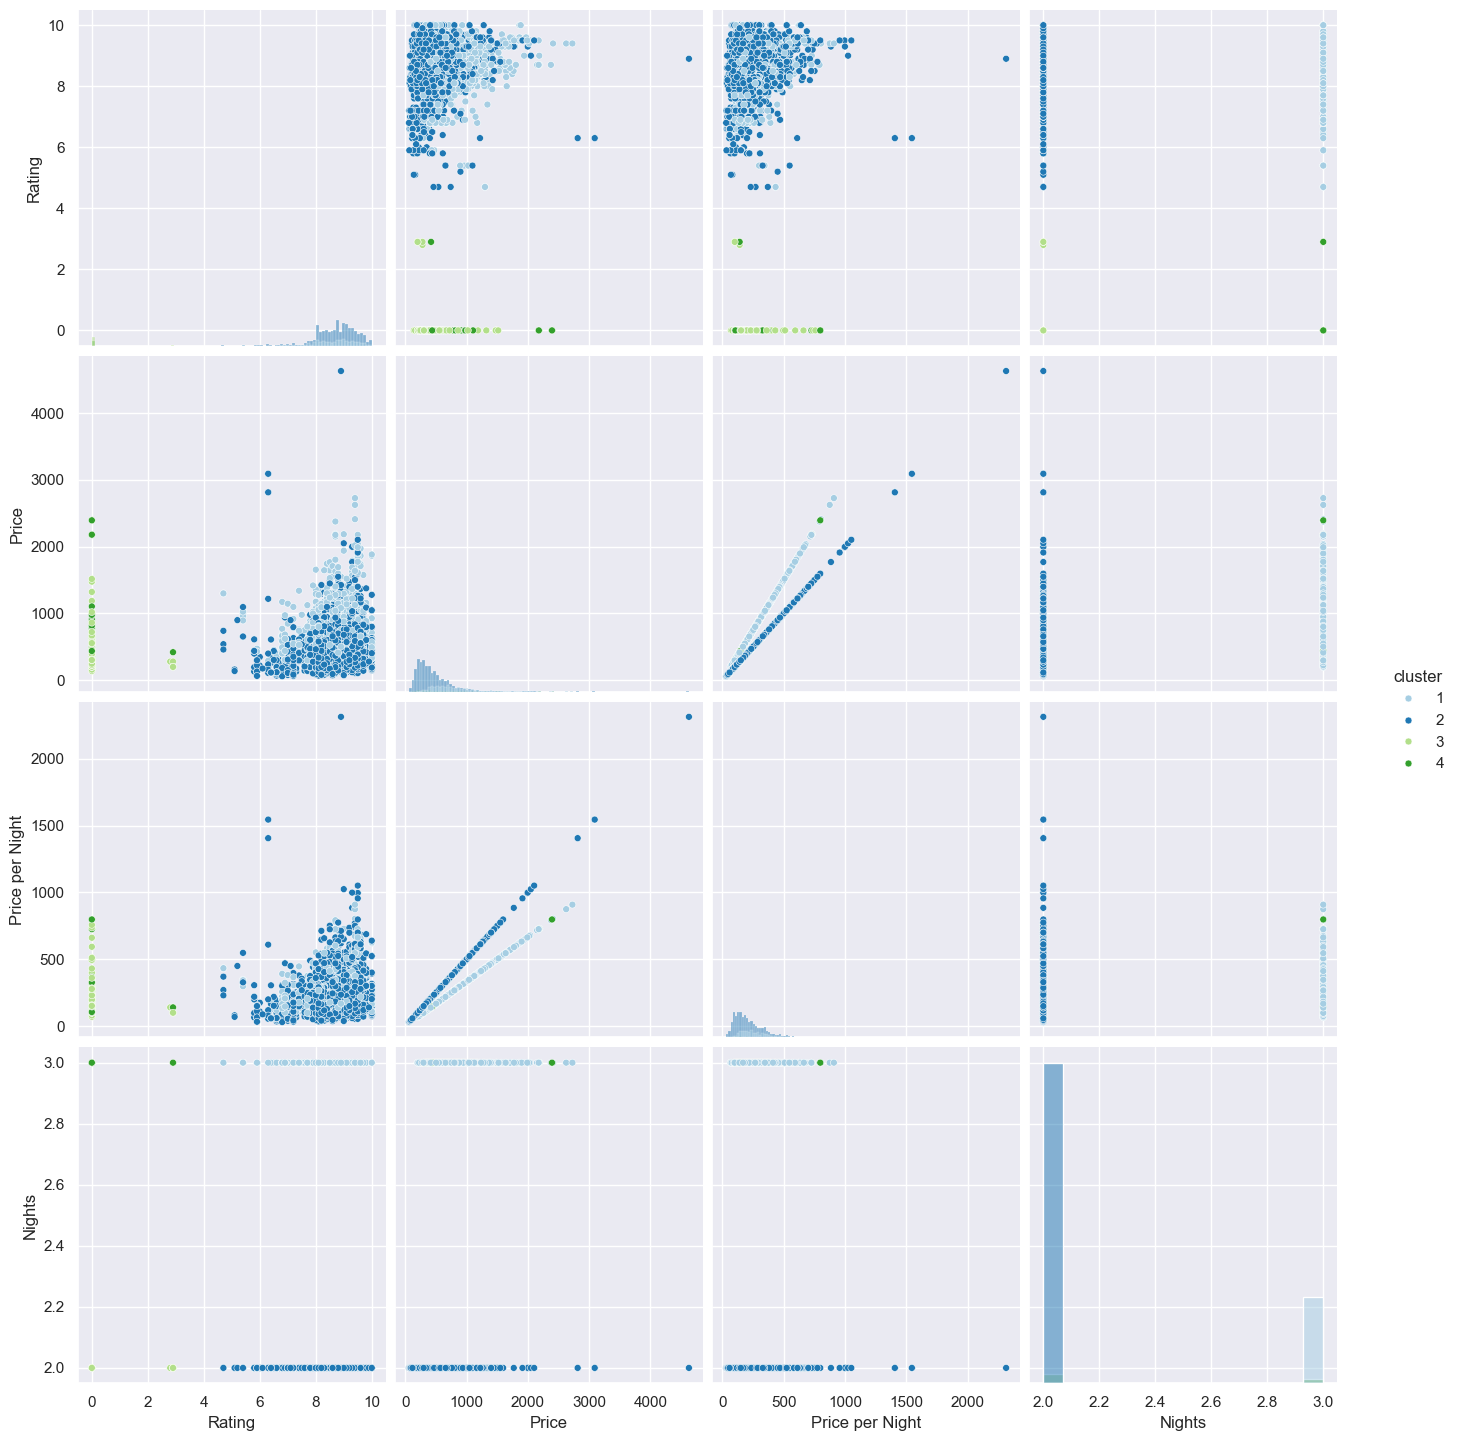

In [151]:
clusters = pd.DataFrame(cluster_predict, index=X.index, columns=['cluster'])

X_kmeans = pd.concat([X, clusters], axis=1)

print("---------- Scatter matrix...")

sns.set()
variables = list(X_kmeans.columns)
variables.remove('cluster')
X_kmeans['cluster'] += 1

sample_size = 5000
X_kmeans_sampled = X_kmeans.sample(n=sample_size, random_state=123456) if len(X_kmeans) > sample_size else X_kmeans

sns_plot = sns.pairplot(
    X_kmeans_sampled,
    vars=variables,
    hue="cluster",
    palette=colors,
    plot_kws={"s": 25},
    diag_kind="hist"
)

sns_plot.fig.subplots_adjust(wspace=0.03, hspace=0.03)
sns_plot.fig.set_size_inches(15, 15)
sns_plot.savefig("scatter.pdf")
plt.show()

X_kmeans['cluster'] -= 1

### Ejecutamos Mean Shift y medimos sus métricas

In [152]:
bw = estimate_bandwidth(X_normal, quantile=0.2, n_samples=500, random_state=123456)
ms = MeanShift(bandwidth=bw, bin_seeding=True)

print("----- Ejecutando MeanShift -----", end='')
t = time.time()
ms.fit(X_normal)
tiempo = time.time() - t
labels = ms.labels_
print(f": {tiempo:.5f} segundos")

clusters = pd.DataFrame(labels, index=X.index, columns=['cluster'])

size = clusters['cluster'].value_counts()

clusters_filtrados = clusters[clusters['cluster'].isin(size[size > 1].index)]

labels_filtrados = clusters_filtrados['cluster'].to_numpy()
X_filtrado = X_normal.loc[clusters_filtrados.index]


----- Ejecutando MeanShift -----: 2.39900 segundos


##### Calinski Harabasz métrica: 

In [153]:
metrics_CH = metrics.calinski_harabasz_score(X_filtrado, labels_filtrados)
print(f"Calinski-Harabasz Index: {metrics_CH:.5f}")

Calinski-Harabasz Index: 515850.78872


##### Silhouette métrica: 

In [154]:
metric_SC = metrics.silhouette_score(
        X_filtrado, 
        labels_filtrados, 
        metric='euclidean', 
        sample_size=floor(muestra_silhouette * len(X_filtrado)), 
        random_state=123456
)
print("Silhouette Coefficient: {:.5f}".format(metric_SC))

Silhouette Coefficient: 0.78588


##### Davies Bouldin métrica: 

In [155]:
metrics_DB = metrics.davies_bouldin_score(X_filtrado, labels_filtrados)
print(f"Davies-Bouldin Index: {metrics_DB:.5f}")

Davies-Bouldin Index: 0.36533


#### Tamaño de los clusters

In [156]:
size = clusters['cluster'].value_counts()

size_filtrados = clusters_filtrados['cluster'].value_counts().sort_index()

print("Tamaño de cada cluster")
for i, (cluster_id, c) in enumerate(size_filtrados.items(), start=1):
    print('%d: %5d (%5.2f%%)' % (i, c, 100 * c / len(clusters_filtrados)))


Tamaño de cada cluster
1: 58136 (76.69%)
2: 15154 (19.99%)
3:  1716 ( 2.26%)
4:   664 ( 0.88%)
5:   134 ( 0.18%)


#### Visualización: Heatmap de centroides

Heatmap de centroides generado para clusters con más de un elemento.


<Figure size 640x480 with 0 Axes>

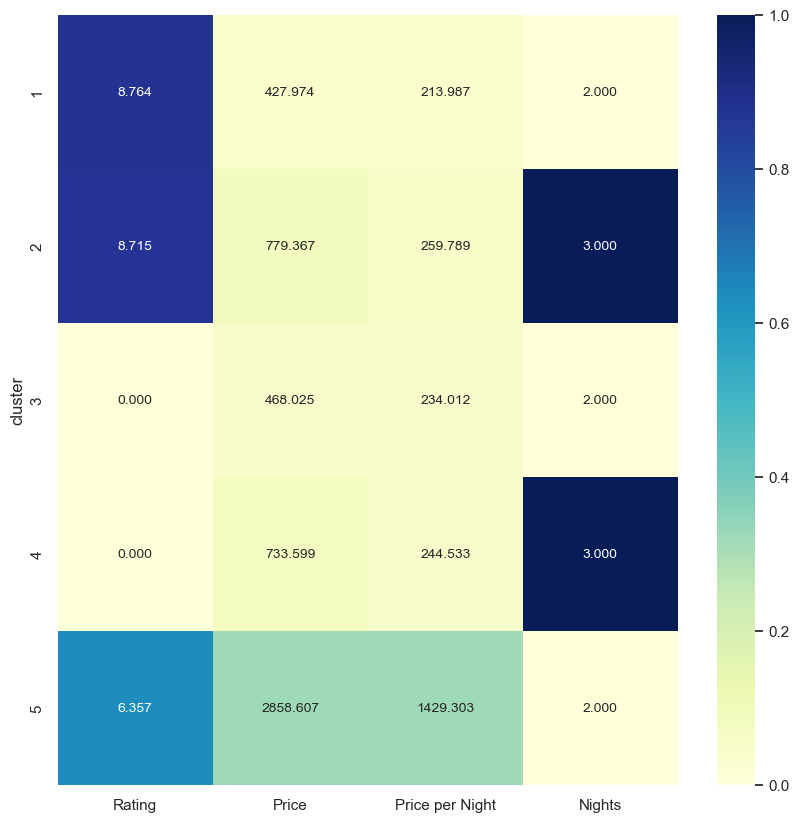

In [157]:
centroides_filtrados = pd.DataFrame(ms.cluster_centers_, columns=X_normal.columns)

centroides_filtrados = centroides_filtrados.loc[size[size > 1].index]

centroides_desnormalizados = centroides_filtrados.copy()

for var in X.columns:
    centroides_desnormalizados[var] = X[var].min() + centroides_filtrados[var] * (X[var].max() - X[var].min())

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
centroides_filtrados.index += 1 
plt.figure()
hm = sns.heatmap(centroides_filtrados, cmap="YlGnBu", annot=centroides_desnormalizados, fmt='.3f', annot_kws={"fontsize": 10})
hm.set_ylim(len(centroides_filtrados), 0)
hm.figure.set_size_inches(10, 10)
hm.figure.savefig("centroides_mean_shift_filtrados.pdf")
centroides_filtrados.index -= 1 

print("Heatmap de centroides generado para clusters con más de un elemento.")



#### Visualización: Scatter Matrix

---------- Scatter matrix...


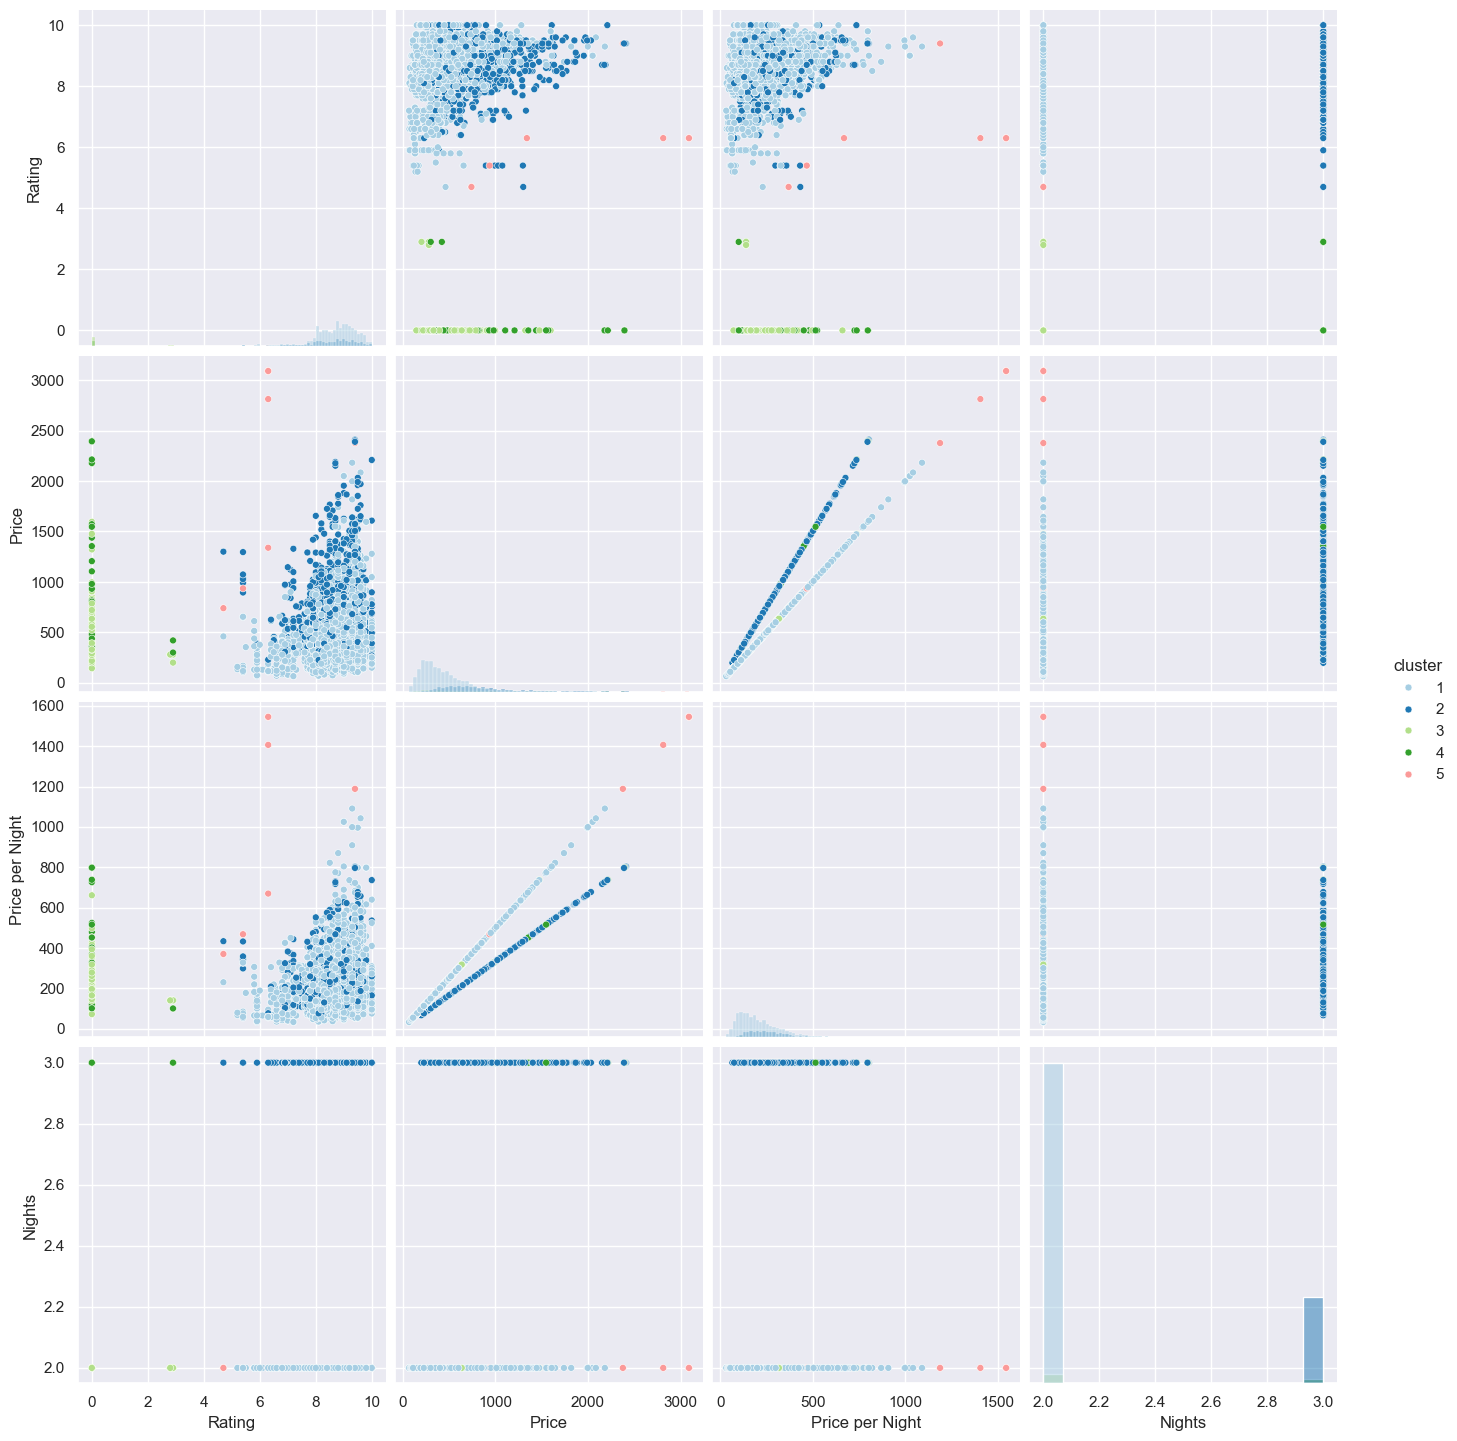

In [158]:
k = len(set(labels_filtrados))
colors = sns.color_palette(palette='Paired', n_colors=k)[:len(set(labels_filtrados))]

clusters_filtrados_df = pd.DataFrame(labels_filtrados, index=X_filtrado.index, columns=['cluster'])
X_meanshift_filtrado = pd.concat([X.loc[X_filtrado.index], clusters_filtrados_df], axis=1)

print("---------- Scatter matrix...")

sns.set()
variables = list(X_meanshift_filtrado.columns)
variables.remove('cluster')
X_meanshift_filtrado['cluster'] += 1 

sample_size = 5000
X_meanshift_sampled = X_meanshift_filtrado.sample(n=sample_size, random_state=123456) if len(X_meanshift_filtrado) > sample_size else X_meanshift_filtrado

sns_plot = sns.pairplot(
    X_meanshift_sampled,
    vars=variables,
    hue="cluster",
    palette=colors,  
    plot_kws={"s": 25},  
    diag_kind="hist"  
)

sns_plot.fig.subplots_adjust(wspace=0.03, hspace=0.03)
sns_plot.fig.set_size_inches(15, 15)
sns_plot.savefig("scatter_meanshift.pdf") 
plt.show()

X_meanshift_filtrado['cluster'] -= 1




### Ejecutamos DBSCAN y medimos sus métricas 

In [159]:
sample_fraction = 0.2
X_dbscan = X_normal.sample(frac=sample_fraction, random_state=42)

eps = 0.6
min_samples = 5 

print("------ Ejecutando DBSCAN ------")
dbscan = DBSCAN(eps=eps, min_samples=min_samples, algorithm="ball_tree", n_jobs=-1)

start_time = time.time()
clusters_dbscan = dbscan.fit_predict(X_dbscan)
end_time = time.time()
print(f"DBSCAN completado en {end_time - start_time:.5f} segundos")

clusters = pd.DataFrame(clusters_dbscan, index=X_dbscan.index, columns=['cluster'])

labels_filtrados = clusters['cluster'].to_numpy()
X_filtrado = X_dbscan.loc[clusters.index]


------ Ejecutando DBSCAN ------
DBSCAN completado en 4.01933 segundos


##### Calinski Harabasz métrica: 

In [160]:
metrics_CH = metrics.calinski_harabasz_score(X_filtrado, labels_filtrados)
print(f"Calinski-Harabasz Index: {metrics_CH:.5f}")

Calinski-Harabasz Index: 84314.27001


##### Silhouette métrica: 

In [161]:
muestra_silhouette = 0.2 if len(X_filtrado) > 10000 else 1.0
metric_SC = metrics.silhouette_score(
        X_filtrado, 
        labels_filtrados, 
        metric='euclidean', 
        sample_size=floor(muestra_silhouette * len(X_filtrado)),
        random_state=123456
)
print(f"Silhouette Coefficient: {metric_SC:.5f}")

Silhouette Coefficient: 0.86448


##### Davies Bouldin métrica: 

In [162]:
metrics_DB = metrics.davies_bouldin_score(X_filtrado, labels_filtrados)
print(f"Davies-Bouldin Index: {metrics_DB:.5f}")

Davies-Bouldin Index: 0.20831


#### Tamaño de los clusters

In [163]:
size = clusters['cluster'].value_counts()

clusters_filtrados = clusters[clusters['cluster'].isin(size[size > 1].index)]

size_filtrados = clusters_filtrados['cluster'].value_counts().sort_index()

print("Tamaño de cada cluster:")
for i, (cluster_id, c) in enumerate(size_filtrados.items(), start=1):
    print('%d: %5d (%5.2f%%)' % (i, c, 100 * c / len(clusters_filtrados)))

Tamaño de cada cluster:
1: 11965 (78.92%)
2:  3196 (21.08%)


#### Visualización: Heatmap de centroides

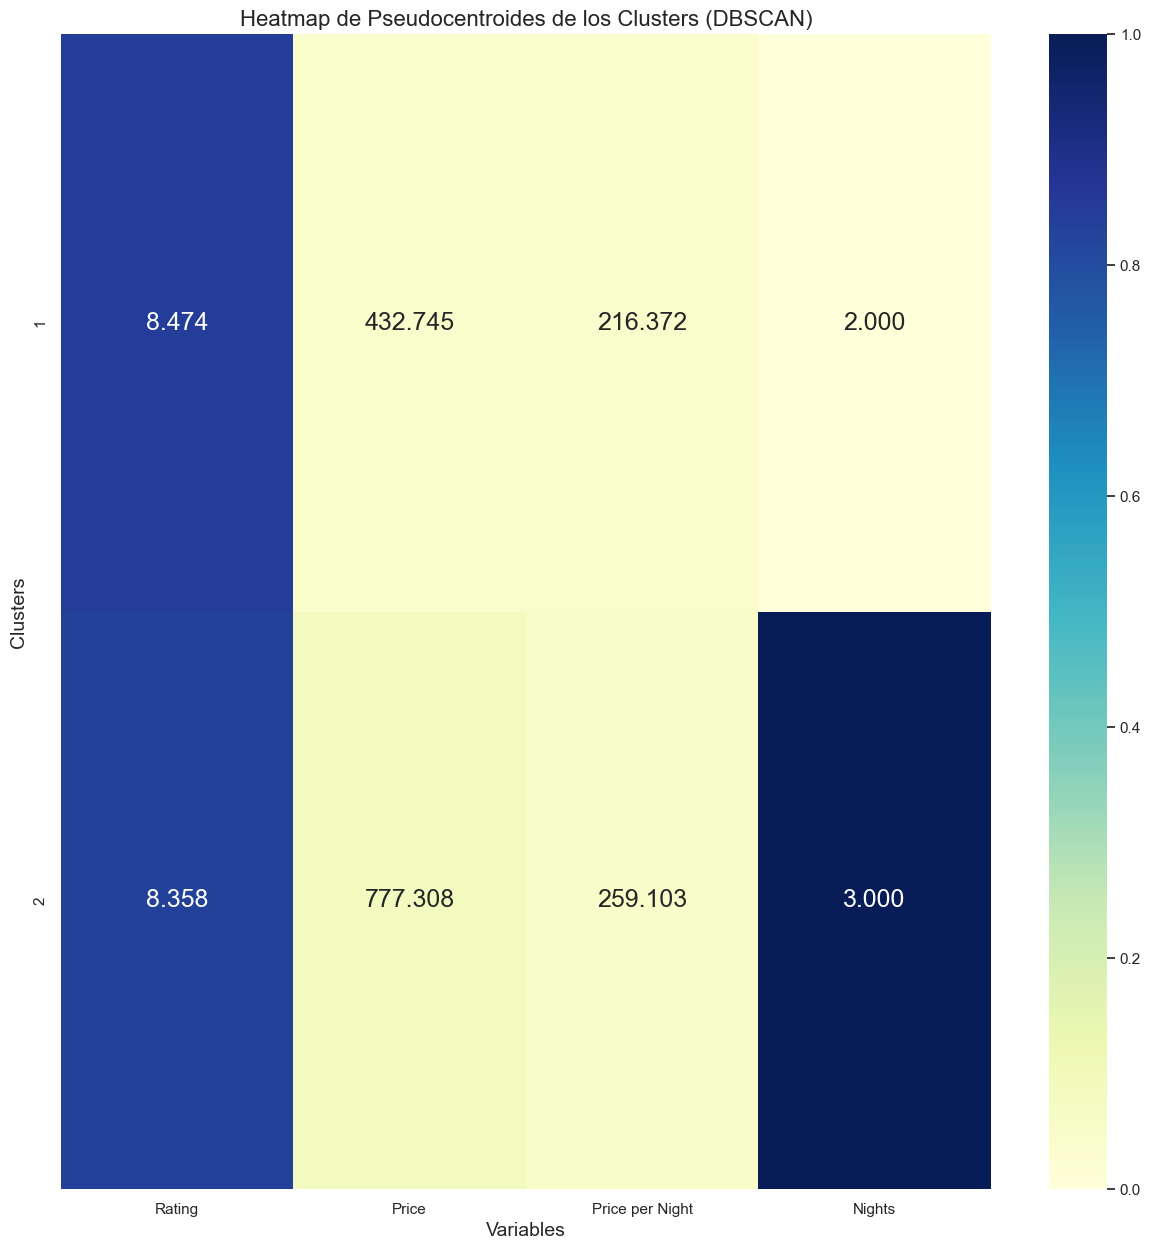

In [164]:
clusters = pd.DataFrame(labels_filtrados, index=X_filtrado.index, columns=['cluster'])

centers = clusters.join(X_filtrado).groupby('cluster').mean()

centers_desnormal = centers.copy()
for var in centers.columns:
    centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())

centers.index += 1 

plt.figure(figsize=(15, 15))
hm = sns.heatmap(
    centers, 
    cmap="YlGnBu", 
    annot=centers_desnormal,
    annot_kws={"fontsize": 18},
    fmt='.3f'
)
hm.set_title("Heatmap de Pseudocentroides de los Clusters (DBSCAN)", fontsize=16)
hm.set_ylabel("Clusters", fontsize=14)
hm.set_xlabel("Variables", fontsize=14)
hm.set_ylim(len(centers), 0)

plt.show()


#### Visualización: Scatter Matrix

---------- Scatter matrix...


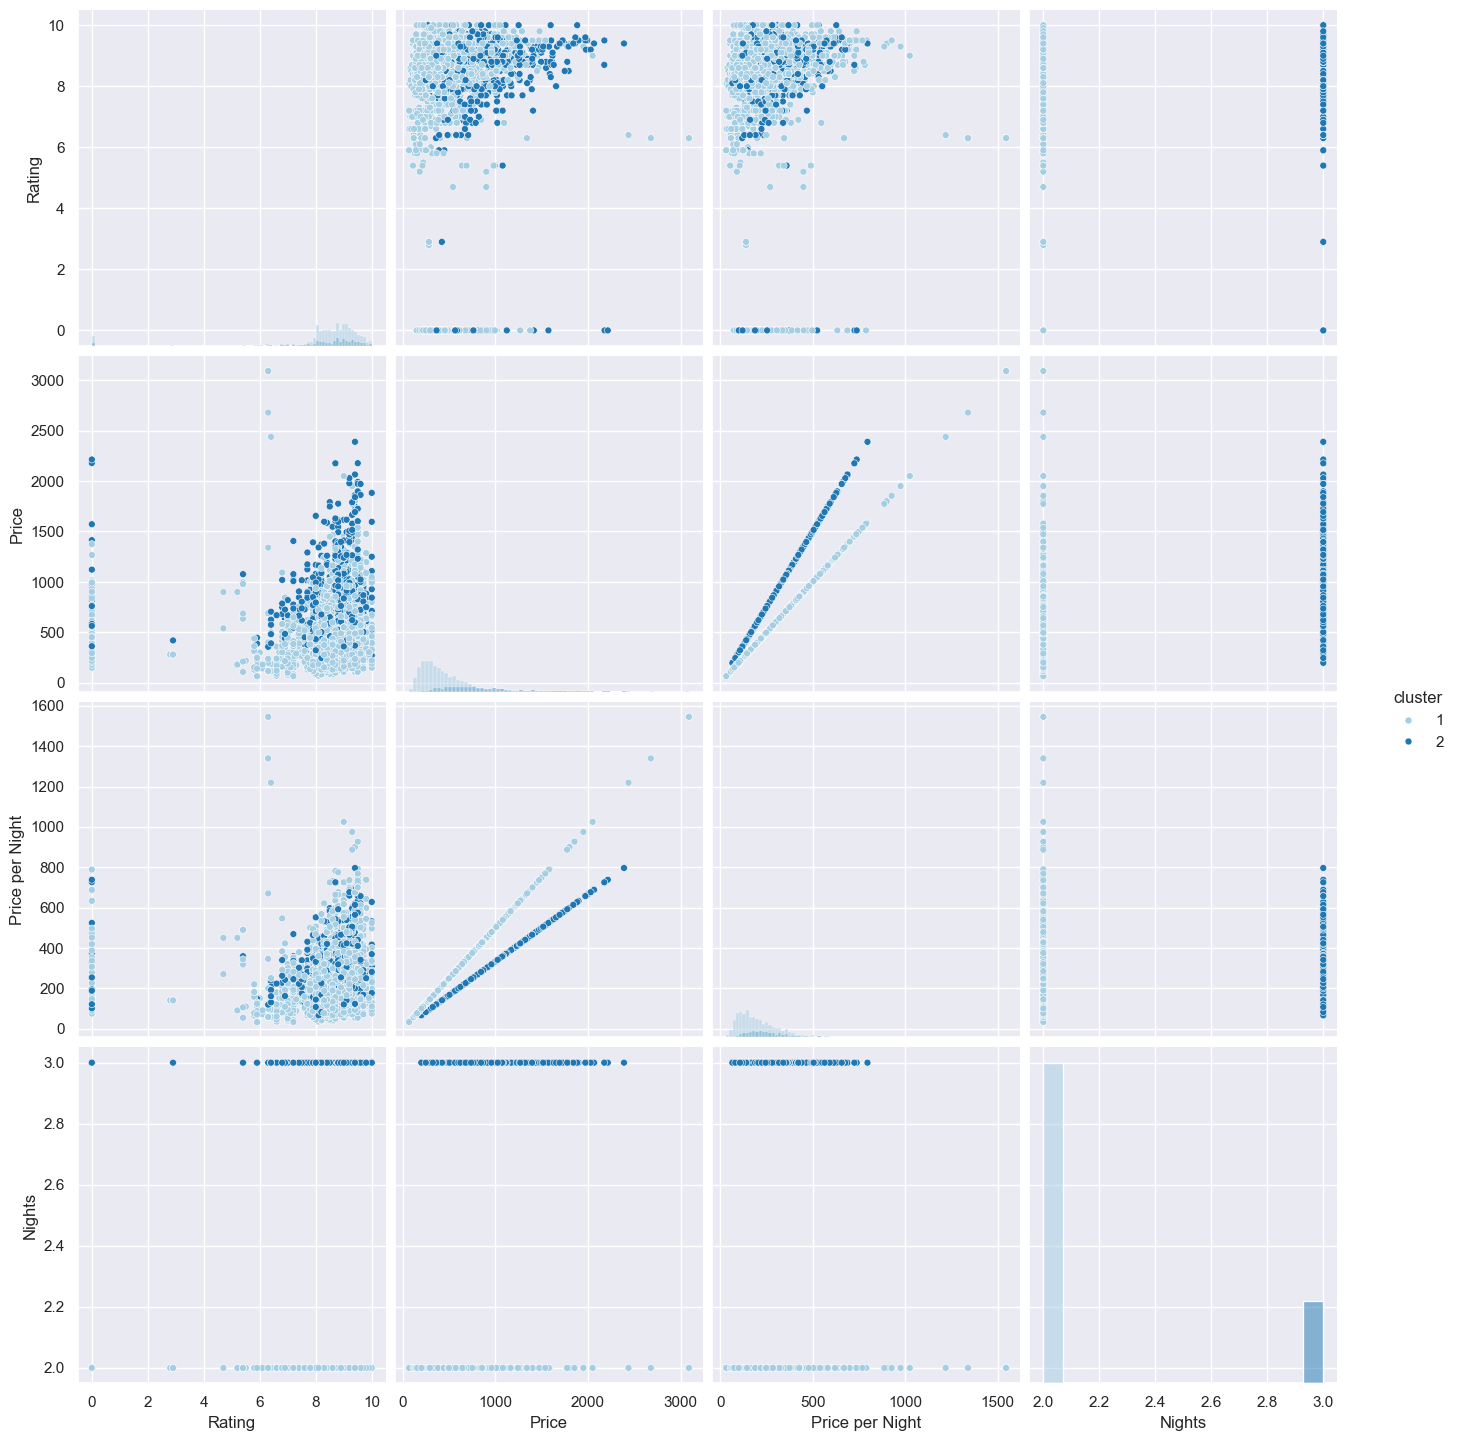

In [165]:
labels_unicos = sorted(set(labels_filtrados) - {-1})
k = len(labels_unicos)
colors = sns.color_palette('Paired', n_colors=k)

clusters_filtrados_df = pd.DataFrame(labels_filtrados, index=X_filtrado.index, columns=['cluster'])
clusters_filtrados_df = clusters_filtrados_df[clusters_filtrados_df['cluster'].isin(labels_unicos)]

X_dbscan_filtrado = pd.concat([X.loc[clusters_filtrados_df.index], clusters_filtrados_df], axis=1)

print("---------- Scatter matrix...")

sns.set()
variables = list(X_dbscan_filtrado.columns)
variables.remove('cluster')
X_dbscan_filtrado['cluster'] += 1  

sample_size = 5000
X_dbscan_sampled = X_dbscan_filtrado.sample(n=sample_size, random_state=123456) if len(X_dbscan_filtrado) > sample_size else X_dbscan_filtrado

sns_plot = sns.pairplot(
    X_dbscan_sampled,
    vars=variables,
    hue="cluster",
    palette=colors,
    plot_kws={"s": 25},
    diag_kind="hist"
)

sns_plot.fig.subplots_adjust(wspace=0.03, hspace=0.03)
sns_plot.fig.set_size_inches(15, 15)
sns_plot.savefig("scatter_dbscan.pdf")
plt.show()

X_dbscan_filtrado['cluster'] -= 1


### Ejecutamos BIRCH y medimos sus métricas 

In [166]:
n_clusters = 4
threshold = 0.2
branching_factor =10

birch = Birch(n_clusters=n_clusters, threshold=threshold, branching_factor=branching_factor)

print("----- Ejecutando BIRCH -----")
start_time = time.time()
labels = birch.fit_predict(X_normal)
end_time = time.time()
print(f"BIRCH completado en {end_time - start_time:.5f} segundos")

clusters = pd.DataFrame(labels, index=X.index, columns=['cluster'])

size = clusters['cluster'].value_counts()

labels_filtrados = clusters['cluster'].to_numpy()
X_filtrado = X_normal.loc[clusters.index]

----- Ejecutando BIRCH -----
BIRCH completado en 2.59801 segundos


##### Calinski Harabasz métrica: 

In [167]:
metric_CH = metrics.calinski_harabasz_score(X_filtrado, labels_filtrados)
print(f"Calinski-Harabasz Index: {metrics_CH:.5f}")

Calinski-Harabasz Index: 84314.27001


##### Silhouette métrica: 

In [168]:
muestra_silhouette = 0.2 if len(X_filtrado) > 10000 else 1.0

metric_SC = metrics.silhouette_score(
    X_filtrado,
    labels_filtrados,
    metric='euclidean',
    sample_size=floor(muestra_silhouette * len(X_filtrado)),
    random_state=42
)
print(f"Silhouette Coefficient: {metric_SC:.5f}")

Silhouette Coefficient: 0.88277


##### Davies Bouldin métrica: 

In [169]:
metric_DB = metrics.davies_bouldin_score(X_filtrado, labels_filtrados)
print(f"Davies-Bouldin Index: {metric_DB:.5f}")


Davies-Bouldin Index: 0.15355


#### Tamaño de los clusters

In [170]:
size = clusters['cluster'].value_counts().sort_index()

print("Tamaño de cada cluster:")
for i, (cluster_id, count) in enumerate(size.items(), start=1):
    print(f"{i}: {count:5d} ({100 * count / len(clusters):5.2f}%)")


Tamaño de cada cluster:
1:   664 ( 0.88%)
2: 15154 (19.99%)
3: 58272 (76.87%)
4:  1716 ( 2.26%)


#### Visualización: Heatmap de centroides

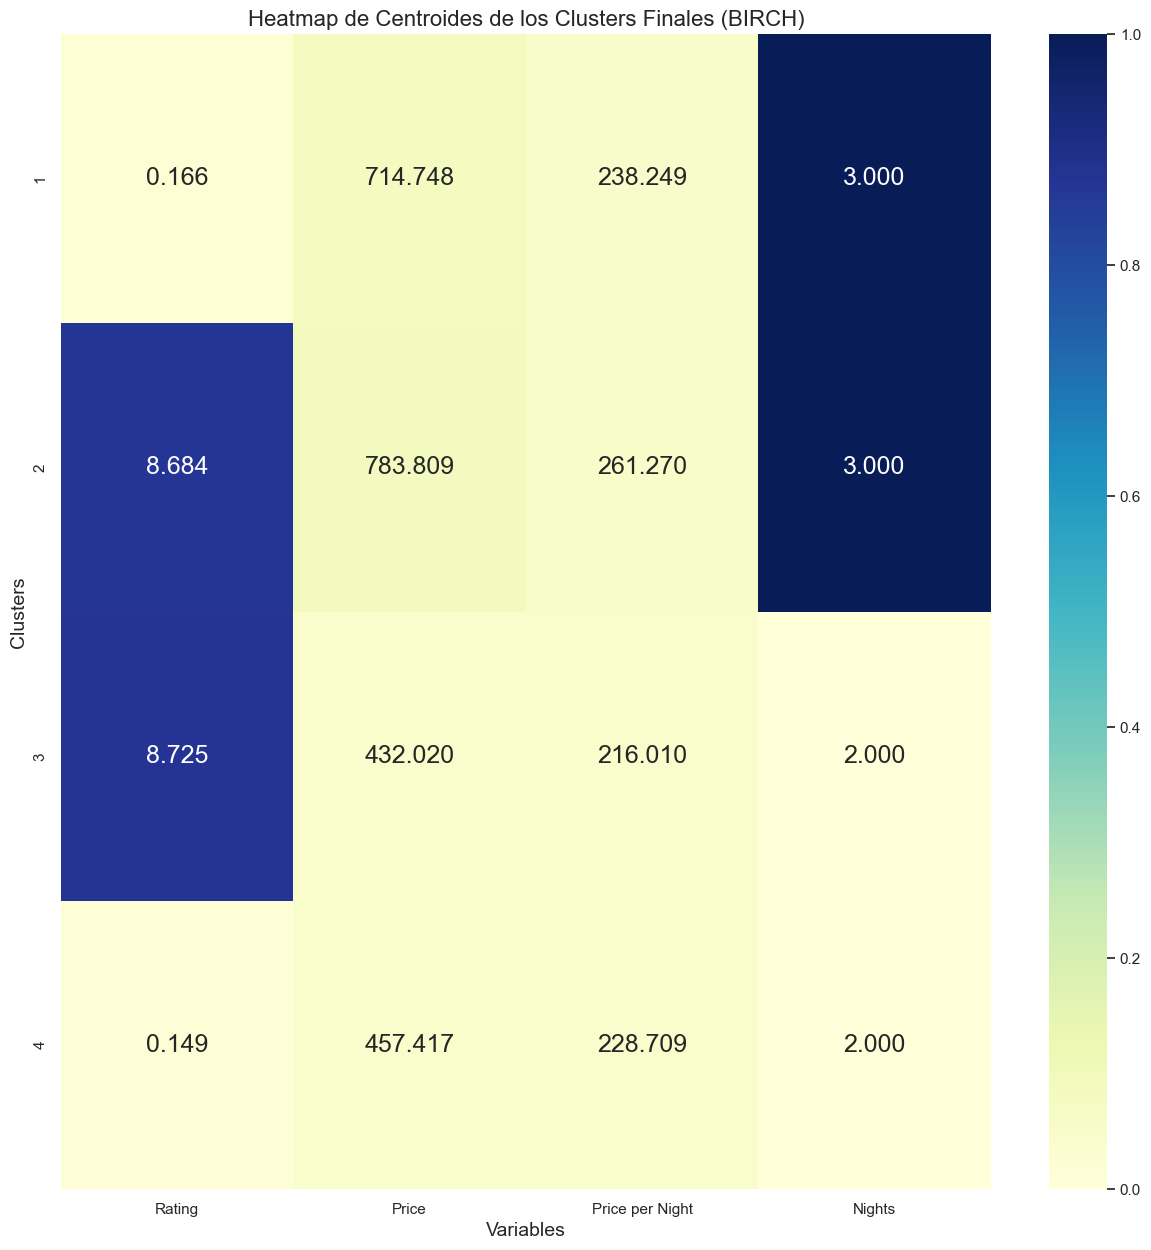

In [171]:
clusters_finales = pd.DataFrame(labels_filtrados, index=X_filtrado.index, columns=['cluster'])

centers_finales = X_filtrado.groupby(clusters_finales['cluster']).mean()

centers_desnormal = centers_finales.copy()
for var in list(centers_finales.columns):
    centers_desnormal[var] = X[var].min() + centers_finales[var] * (X[var].max() - X[var].min())

centers_finales.index += 1

plt.figure(figsize=(15, 15))
hm = sns.heatmap(
    centers_finales, 
    cmap="YlGnBu", 
    annot=centers_desnormal,
    annot_kws={"fontsize": 18},
    fmt='.3f'
)
hm.set_title("Heatmap de Centroides de los Clusters Finales (BIRCH)", fontsize=16)
hm.set_ylabel("Clusters", fontsize=14)
hm.set_xlabel("Variables", fontsize=14)
hm.set_ylim(len(centers_finales), 0)

plt.show()


#### Visualización: Scatter Matrix

---------- Scatter matrix...


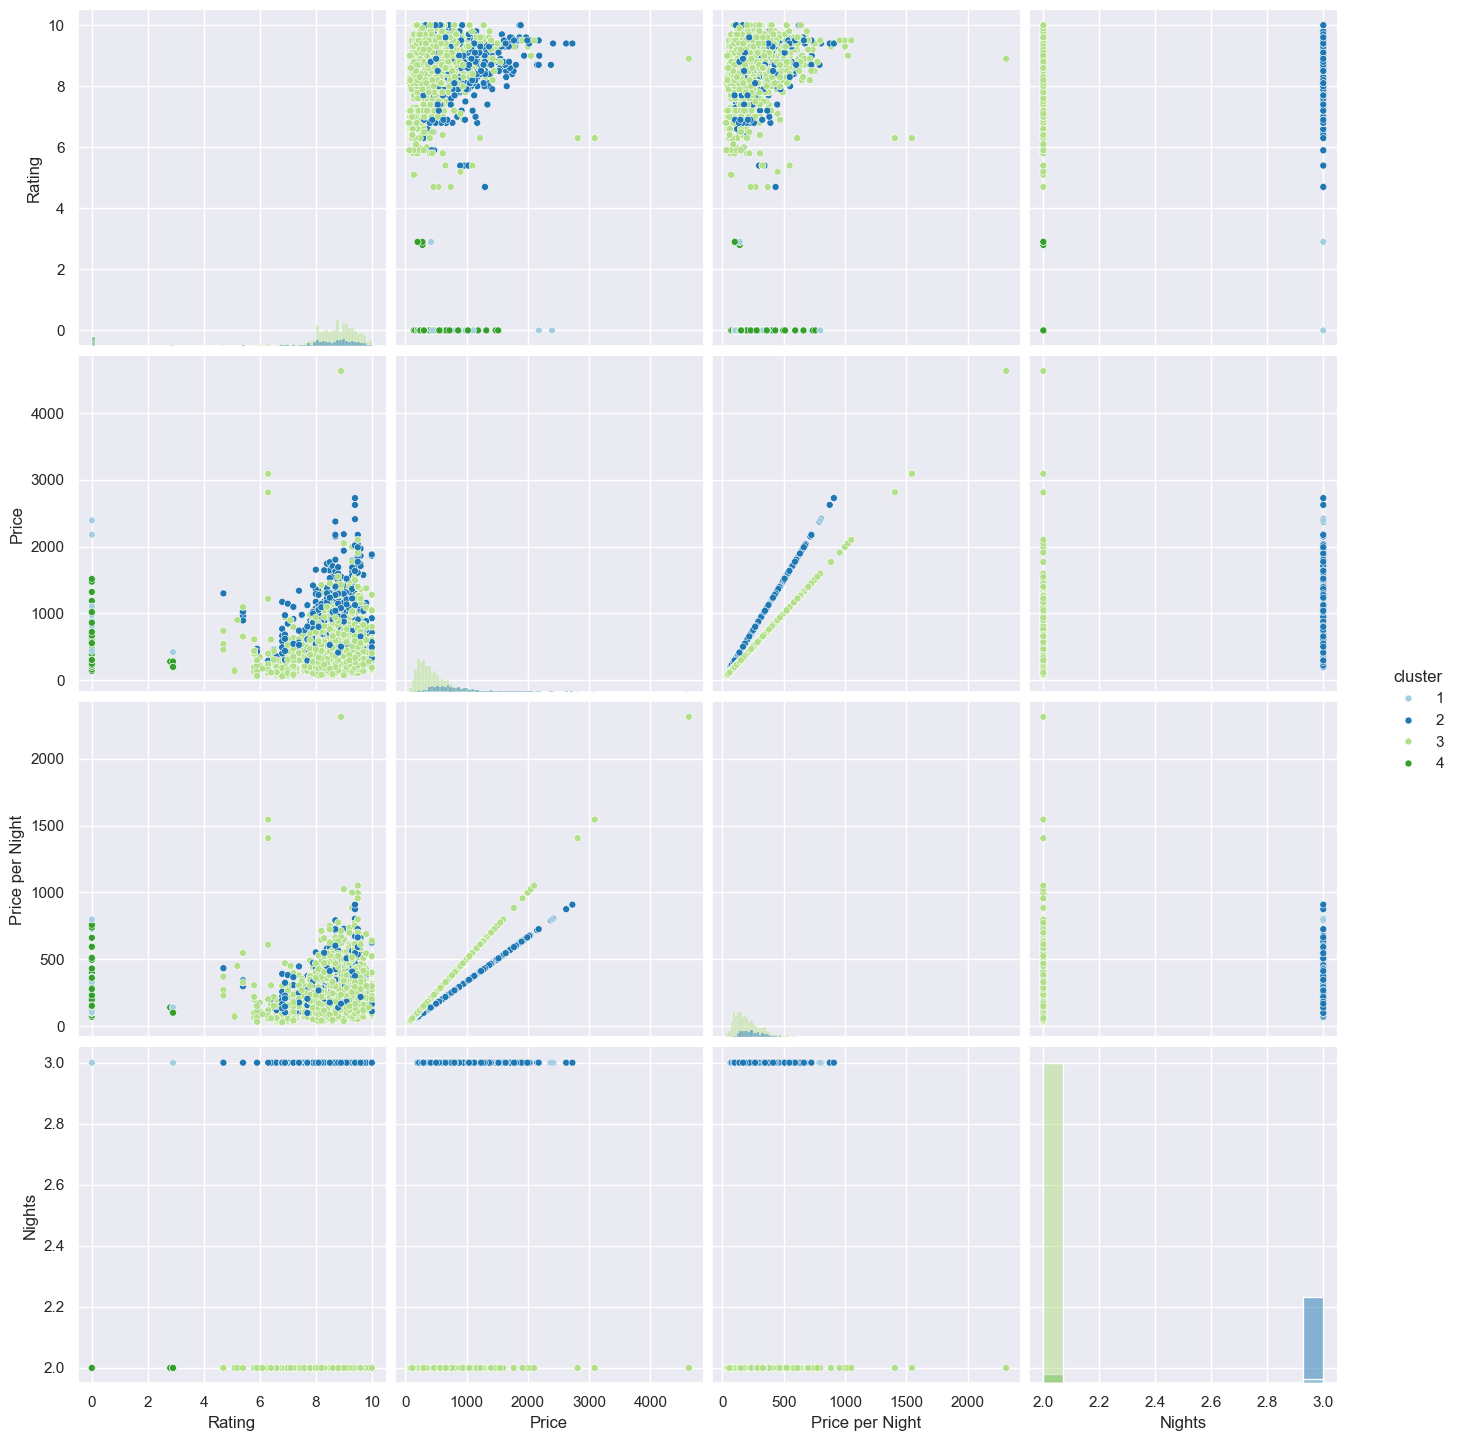

In [172]:
k = len(set(labels_filtrados))
colors = sns.color_palette(palette='Paired', n_colors=k)

clusters_filtrados_df = pd.DataFrame(labels_filtrados, index=X_filtrado.index, columns=['cluster'])

X_birch_filtrado = pd.concat([X.loc[X_filtrado.index], clusters_filtrados_df], axis=1)

print("---------- Scatter matrix...")

sns.set()
variables = list(X_birch_filtrado.columns)
variables.remove('cluster')
X_birch_filtrado['cluster'] += 1 

sample_size = 5000
X_birch_sampled = X_birch_filtrado.sample(n=sample_size, random_state=123456) if len(X_birch_filtrado) > sample_size else X_birch_filtrado

sns_plot = sns.pairplot(
    X_birch_sampled,
    vars=variables,
    hue="cluster",
    palette=colors,  
    plot_kws={"s": 25},  
    diag_kind="hist"  
)

sns_plot.fig.subplots_adjust(wspace=0.03, hspace=0.03) 
sns_plot.fig.set_size_inches(15, 15)  
sns_plot.savefig("scatter_birch.pdf")  
plt.show()

X_birch_filtrado['cluster'] -= 1  


### Ejecutamos Método Jerárquico Aglomerativo de Enlace Simple

In [173]:
n_clusters = 3
linkage = "single"

agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric="euclidean")

print("----- Ejecutando Método Jerárquico (Enlace Simple) -----")
start_time = time.time()
labels = agg_clustering.fit_predict(X_normal)
end_time = time.time()
print(f"Método jerárquico completado en {end_time - start_time:.2f} segundos")

clusters = pd.DataFrame(labels, index=X_normal.index, columns=['cluster'])

labels_filtrados = clusters['cluster'].to_numpy()
X_filtrado = X_normal.loc[clusters.index]


----- Ejecutando Método Jerárquico (Enlace Simple) -----
Método jerárquico completado en 76.23 segundos


##### Calinski Harabasz métrica: 

In [174]:
metric_CH = metrics.calinski_harabasz_score(X_filtrado, labels_filtrados)
print(f"Calinski-Harabasz Index: {metric_CH:.5f}")


Calinski-Harabasz Index: 212969.07792


##### Silhouette métrica: 

In [175]:
muestra_silhouette = 0.2 if len(X_filtrado) > 10000 else 1.0

metric_SC = metrics.silhouette_score(
    X_filtrado,
    labels_filtrados,
    metric='euclidean',
    sample_size=floor(muestra_silhouette * len(X_filtrado)),
    random_state=42
)
print(f"Silhouette Coefficient: {metric_SC:.5f}")

Silhouette Coefficient: 0.86324


##### Davies Bouldin métrica: 

In [176]:
metric_DB = metrics.davies_bouldin_score(X_filtrado, labels_filtrados)
print(f"Davies-Bouldin Index: {metric_DB:.5f}")

Davies-Bouldin Index: 0.16252


#### Tamaño de los clusters

In [177]:
size = clusters['cluster'].value_counts()

size_filtrados = clusters['cluster'].value_counts().sort_index()

print("Tamaño de cada cluster (Jerárquico Aglomerativo):")
for i, (cluster_id, c) in enumerate(size_filtrados.items(), start=1):
    print('%d: %5d (%5.2f%%)' % (i, c, 100 * c / len(clusters_filtrados)))


Tamaño de cada cluster (Jerárquico Aglomerativo):
1: 59987 (395.67%)
2: 15818 (104.33%)
3:     1 ( 0.01%)


#### Visualización: Heatmap de centroides

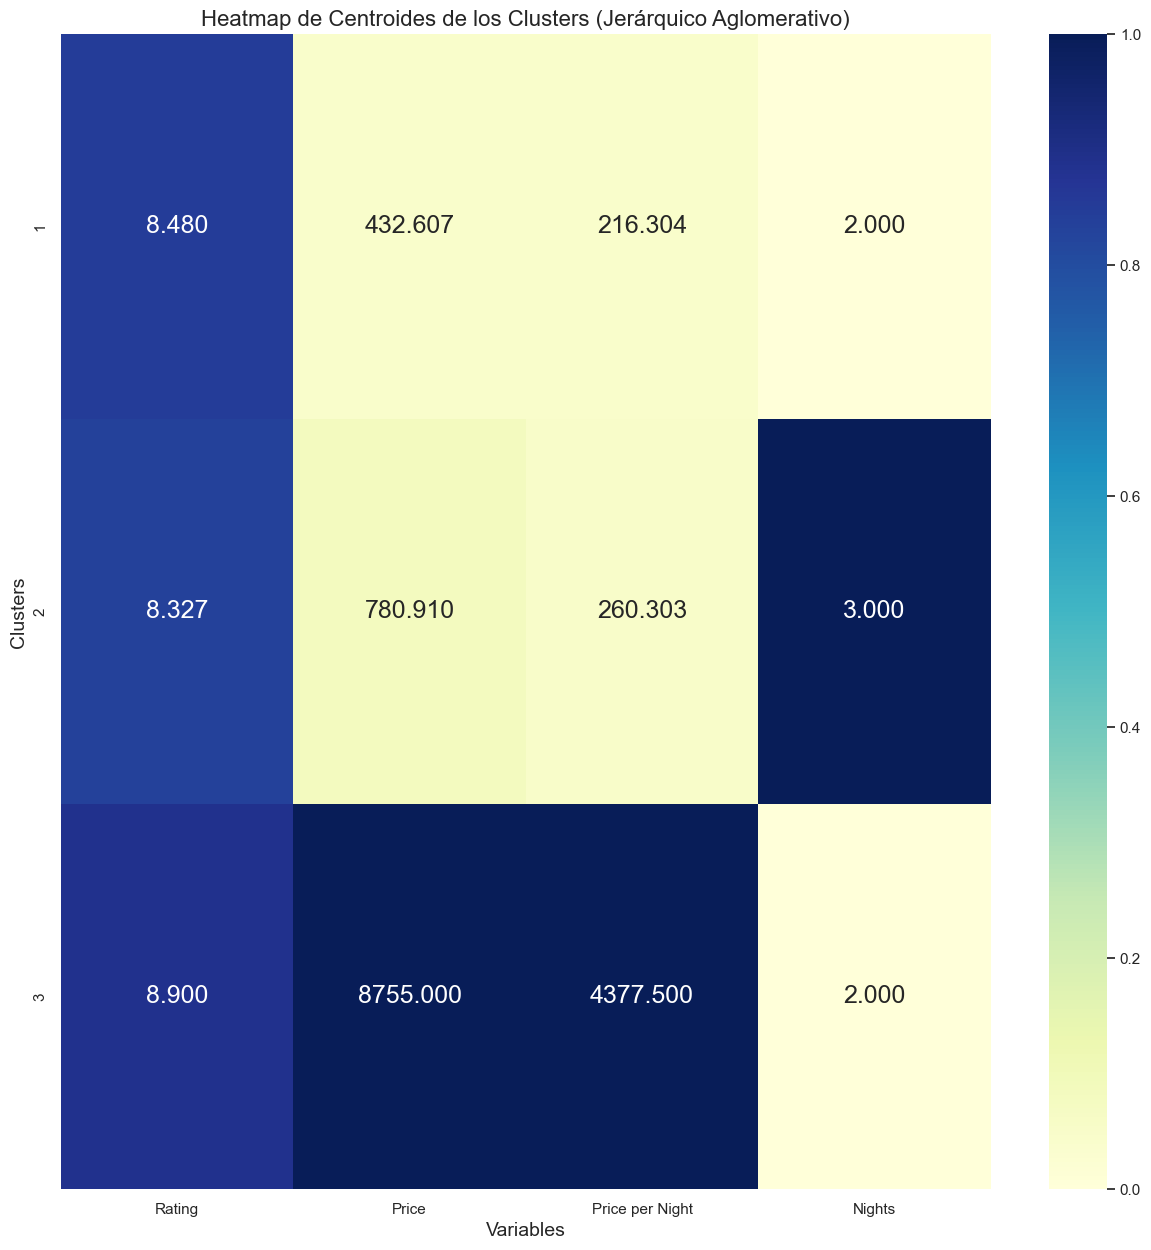

In [178]:
centers = pd.DataFrame([
    X_filtrado[labels_filtrados == cluster_id].mean()
    for cluster_id in np.unique(labels_filtrados)
], columns=list(X_normal))

centers_desnormal = centers.copy()
for var in list(centers):
    centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())

centers.index += 1  

plt.figure(figsize=(15, 15))
hm = sns.heatmap(
    centers, 
    cmap="YlGnBu", 
    annot=centers_desnormal,
    annot_kws={"fontsize": 18},
    fmt='.3f'
)
hm.set_title("Heatmap de Centroides de los Clusters (Jerárquico Aglomerativo)", fontsize=16)
hm.set_ylabel("Clusters", fontsize=14)
hm.set_xlabel("Variables", fontsize=14)
hm.set_ylim(len(centers), 0)

plt.show()


#### Visualización: Dendograma

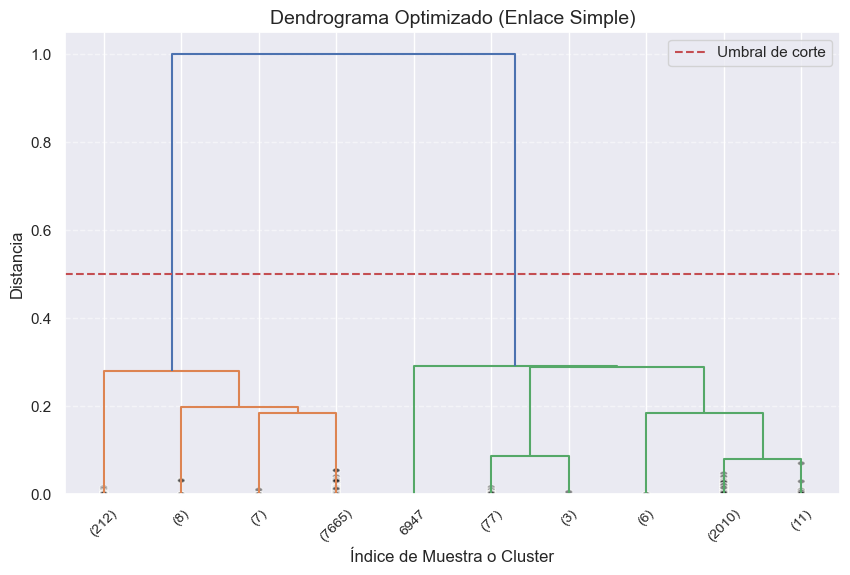

In [179]:
from scipy.cluster.hierarchy import linkage, dendrogram

X_sample = X_normal.sample(n=10000, random_state=123)

Z = linkage(X_sample, method='single')

plt.figure(figsize=(10, 6))
dendrogram(
    Z,
    truncate_mode="lastp", 
    p=10,                  
    leaf_rotation=45,      
    leaf_font_size=10,     
    show_contracted=True   
)

plt.axhline(y=0.5, color='r', linestyle='--', label="Umbral de corte")
plt.title("Dendrograma Optimizado (Enlace Simple)", fontsize=14)
plt.xlabel("Índice de Muestra o Cluster", fontsize=12)
plt.ylabel("Distancia", fontsize=12)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


#### Visualización: Scatter Matrix

---------- Scatter matrix...


c:\Users\janto\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\janto\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\janto\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\janto\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\janto\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)
c:\Users\janto\anaconda3\Lib\s

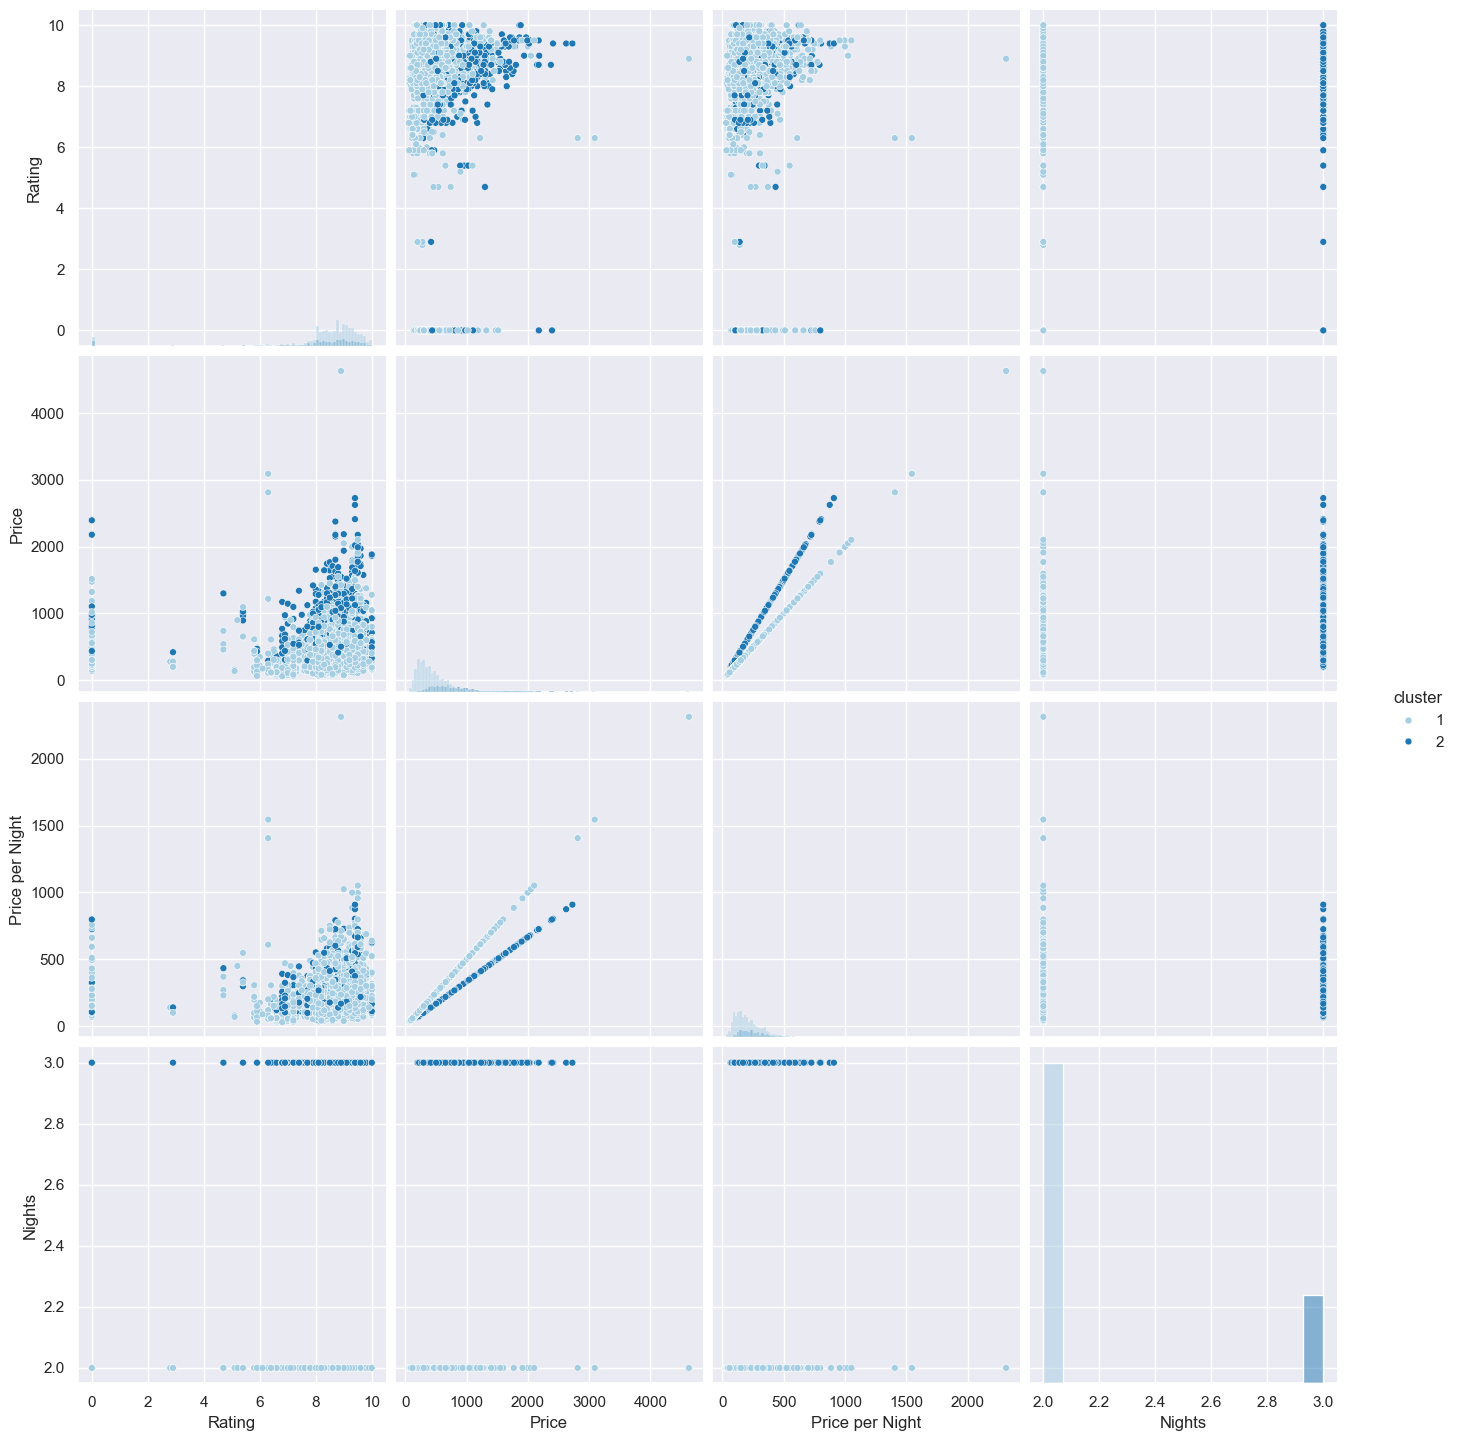

In [180]:
k = len(set(labels_filtrados))
colors = sns.color_palette(palette='Paired', n_colors=k)

clusters_filtrados_df = pd.DataFrame(labels_filtrados, index=X_filtrado.index, columns=['cluster'])

X_hierarchical_filtrado = pd.concat([X.loc[X_filtrado.index], clusters_filtrados_df], axis=1)

print("---------- Scatter matrix...")

sns.set()
variables = list(X_hierarchical_filtrado.columns)
variables.remove('cluster')
X_hierarchical_filtrado['cluster'] += 1 

sample_size = 5000
X_hierarchical_sampled = X_hierarchical_filtrado.sample(n=sample_size, random_state=123456) if len(X_hierarchical_filtrado) > sample_size else X_hierarchical_filtrado

sns_plot = sns.pairplot(
    X_hierarchical_sampled,
    vars=variables,
    hue="cluster",
    palette=colors,  
    plot_kws={"s": 25},  
    diag_kind="hist"  
)

sns_plot.fig.subplots_adjust(wspace=0.03, hspace=0.03) 
sns_plot.fig.set_size_inches(15, 15)  
sns_plot.savefig("scatter_hierarchical.pdf")  
plt.show()

X_hierarchical_filtrado['cluster'] -= 1  
